In [3]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=0024ca946295f4e644705c508002b068560d68e6ddefd86fe2ed8237a24924c1
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


<ipython-input-12-bfabb17bd0ea>:7: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)
<ipython-input-12-bfabb17bd0ea>:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Avg.Price'].fillna(method='ffill', inplace=True)
<ipython-input-12-bfabb17bd0ea>:30: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Avg.Price'].fillna(method='ffill', inplace=True)
<i

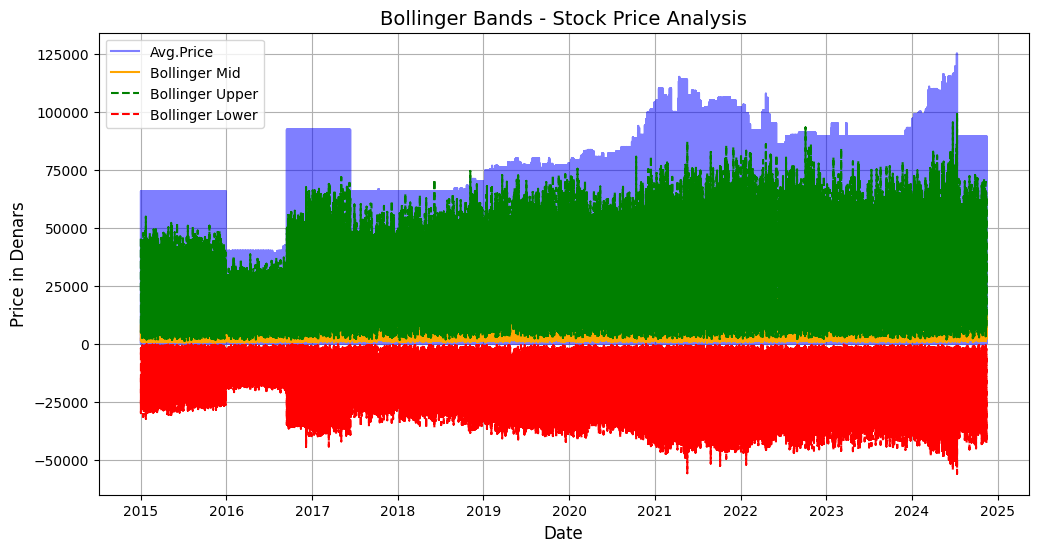

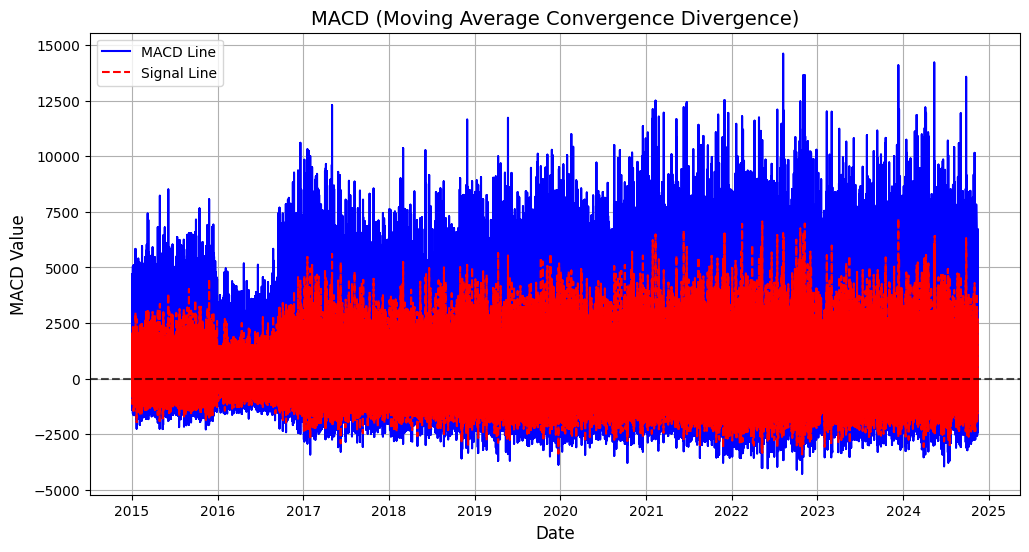

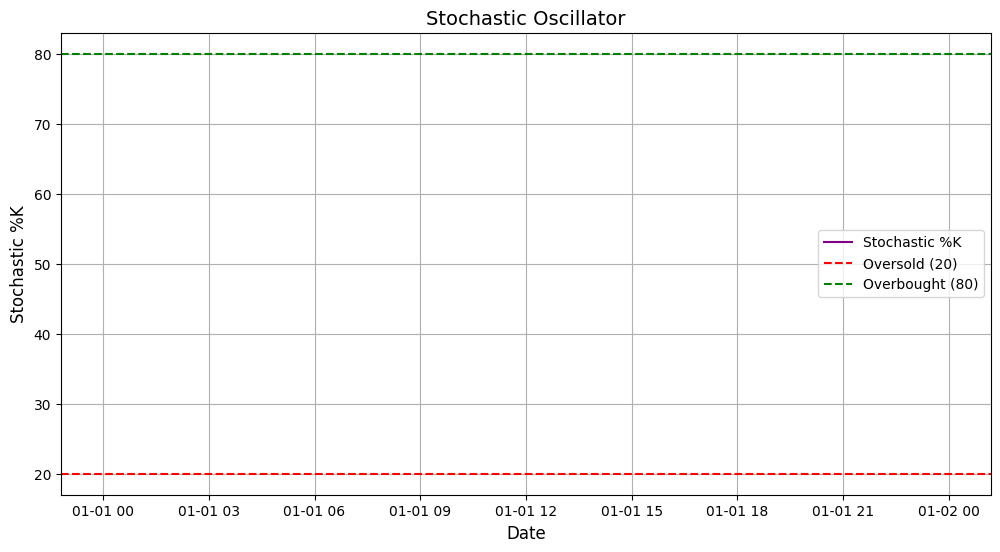

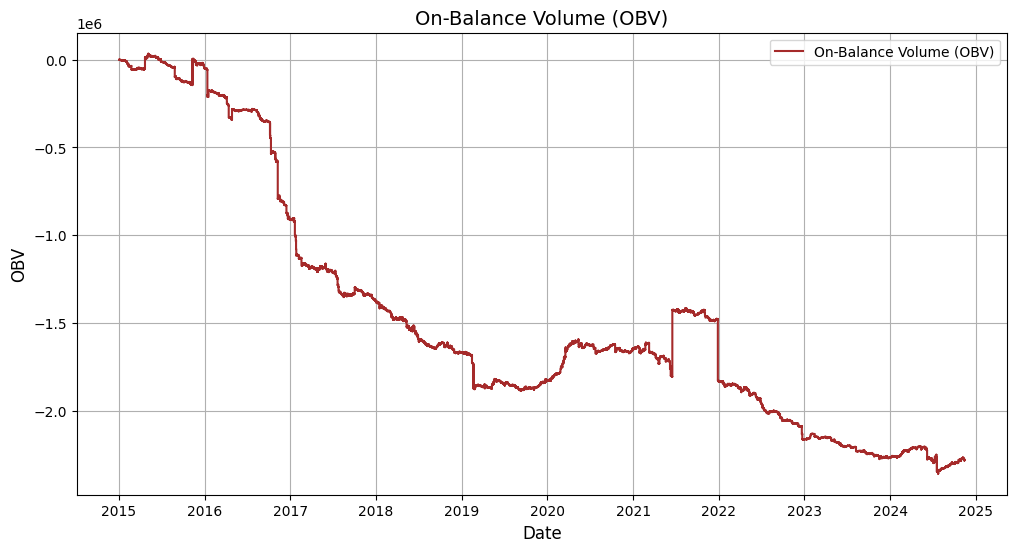

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
file_path = 'issuer_data.csv'
try:
    data = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"File not found: {file_path}")
    exit()
except pd.errors.EmptyDataError:
    print("No data in the file.")
    exit()

# Data Cleaning
# Convert numeric columns to appropriate formats, removing commas where necessary
numeric_columns = ['Last trade price', 'Max', 'Min', 'Avg.Price', 'Volume',
                   'Turnover in BEST in denars', 'Total turnover in denars']

for col in numeric_columns:
    data[col] = data[col].str.replace(',', '').astype(float, errors='ignore')

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y', errors='coerce')

# Drop rows where 'Avg.Price' or 'Date' is missing since they are critical for analysis
data = data.dropna(subset=['Avg.Price', 'Date']).sort_values('Date').reset_index(drop=True)

# Fill missing values if needed
data['Avg.Price'].fillna(method='ffill', inplace=True)
data['Volume'].fillna(0, inplace=True)

# Technical Indicators

# Bollinger Bands
def calculate_bollinger_bands(prices, window=20, num_std_dev=2):
    sma = prices.rolling(window=window).mean()
    std_dev = prices.rolling(window=window).std()
    upper_band = sma + (std_dev * num_std_dev)
    lower_band = sma - (std_dev * num_std_dev)
    return sma, upper_band, lower_band

data['BB_Mid'], data['BB_Upper'], data['BB_Lower'] = calculate_bollinger_bands(data['Avg.Price'])

# MACD (Moving Average Convergence Divergence)
def calculate_macd(prices, short_window=12, long_window=26, signal_window=9):
    ema_short = prices.ewm(span=short_window, adjust=False).mean()
    ema_long = prices.ewm(span=long_window, adjust=False).mean()
    macd_line = ema_short - ema_long
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()
    return macd_line, signal_line

data['MACD_Line'], data['Signal_Line'] = calculate_macd(data['Avg.Price'])

# Stochastic Oscillator
def calculate_stochastic(prices, low, high, window=14):
    lowest_low = low.rolling(window=window).min()
    highest_high = high.rolling(window=window).max()
    k_percent = 100 * (prices - lowest_low) / (highest_high - lowest_low)
    return k_percent

data['Stochastic_%K'] = calculate_stochastic(data['Avg.Price'], data['Min'], data['Max'])

# On-Balance Volume (OBV)
def calculate_obv(prices, volume):
    obv = [0]
    for i in range(1, len(prices)):
        if prices[i] > prices[i - 1]:
            obv.append(obv[-1] + volume[i])
        elif prices[i] < prices[i - 1]:
            obv.append(obv[-1] - volume[i])
        else:
            obv.append(obv[-1])
    return pd.Series(obv, index=prices.index)

data['OBV'] = calculate_obv(data['Avg.Price'], data['Volume'])

# Additional Moving Averages
data['SMA'] = data['Avg.Price'].rolling(window=50).mean()  # Simple Moving Average (50 days)
data['EMA'] = data['Avg.Price'].ewm(span=50, adjust=False).mean()  # Exponential Moving Average (50 days)

# Visualizations
def plot_bollinger_bands():
    plt.figure(figsize=(12, 6))
    plt.plot(data['Date'], data['Avg.Price'], label='Avg.Price', color='blue', alpha=0.5)
    plt.plot(data['Date'], data['BB_Mid'], label='Bollinger Mid', color='orange')
    plt.plot(data['Date'], data['BB_Upper'], label='Bollinger Upper', color='green', linestyle='--')
    plt.plot(data['Date'], data['BB_Lower'], label='Bollinger Lower', color='red', linestyle='--')
    plt.title('Bollinger Bands - Stock Price Analysis', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price in Denars', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_macd():
    plt.figure(figsize=(12, 6))
    plt.plot(data['Date'], data['MACD_Line'], label='MACD Line', color='blue')
    plt.plot(data['Date'], data['Signal_Line'], label='Signal Line', color='red', linestyle='--')
    plt.axhline(0, color='black', linestyle='--', alpha=0.7)
    plt.title('MACD (Moving Average Convergence Divergence)', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('MACD Value', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_stochastic():
    plt.figure(figsize=(12, 6))
    plt.plot(data['Date'], data['Stochastic_%K'], label='Stochastic %K', color='purple')
    plt.axhline(20, color='red', linestyle='--', label='Oversold (20)')
    plt.axhline(80, color='green', linestyle='--', label='Overbought (80)')
    plt.title('Stochastic Oscillator', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Stochastic %K', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_obv():
    plt.figure(figsize=(12, 6))
    plt.plot(data['Date'], data['OBV'], label='On-Balance Volume (OBV)', color='brown')
    plt.title('On-Balance Volume (OBV)', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('OBV', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot all technical indicators
plot_bollinger_bands()
plot_macd()
plot_stochastic()
plot_obv()
